In [188]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim

In [189]:
data = pd.read_pickle('df_exp1.pkl')
string_features = data.select_dtypes(include=['object']).columns.tolist()
print("String features:", string_features)

String features: ['C Messreihe ', 'F DMS ']


In [190]:
encoder = OrdinalEncoder()
data[string_features] = encoder.fit_transform(data[string_features])

In [201]:
features = data.drop(columns=["N AufgewAmplitudeNom [MPa]"])
y = data["N AufgewAmplitudeNom [MPa]"]

In [204]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
X = pd.DataFrame(scaled_features, columns=features.columns)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [206]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

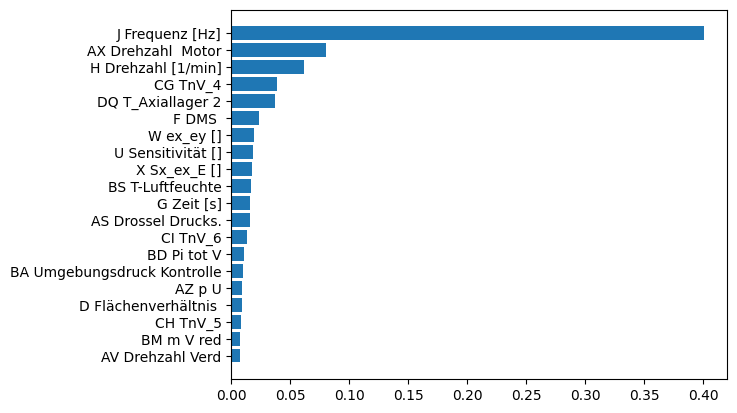

In [207]:
f_i = list(zip(X.columns, rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[-20:]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()


In [210]:
indices = np.argsort(rf.feature_importances_)[::-1]
selected_features_rf = X.columns[indices[:15]]

In [187]:
rfe = RFECV(rf, cv=5, scoring="neg_mean_squared_error", n_jobs=4)
rfe.fit(X_train, y_train)

KeyboardInterrupt: 

In [49]:
selected_features_rfe = np.array(X.columns)[rfe.get_support()]
selected_features_rfe

array(['F DMS ', 'G Zeit [s]', 'H Drehzahl [1/min]', 'J Frequenz [Hz]',
       'U Sensitivität []', 'W ex_ey []', 'AS Drossel Drucks.',
       'AX Drehzahl  Motor', 'BA Umgebungsdruck Kontrolle', 'BM m V red',
       'BS T-Luftfeuchte', 'BV TvV_2', 'CG TnV_4', 'CI TnV_6',
       'CL p_stat_SEALING-COVER_01', 'DQ T_Axiallager 2'], dtype=object)

In [212]:
mi = mutual_info_regression(X, y)
mi_indices = np.argsort(mi)[::-1]
selected_features_mi = X.columns[mi_indices[:15]]

In [213]:
X_selected = X[selected_features_rf]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [214]:
lr_model = LinearRegression()
lr_model.fit(X_train_1, y_train_1)
y_pred_lr_model = lr_model.predict(X_test_1)
mse_lr_model = mean_squared_error(y_test_1, y_pred_lr_model)
print("Linear Regression MSE:", mse_lr_model)


Linear Regression MSE: 38.520288087760186


In [215]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_1, y_train_1)
y_pred_dt_model = dt_model.predict(X_test_1)
mse_dt_model = mean_squared_error(y_test_1, y_pred_dt_model)

param_grid_dt_model = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_dt_model = GridSearchCV(dt_model, param_grid_dt_model, cv=5, scoring='neg_mean_squared_error')
grid_search_dt_model.fit(X_train_1, y_train_1)

best_dt_model = grid_search_dt_model.best_estimator_
y_pred_dt_model_hyper = best_dt_model.predict(X_test_1)
mse_dt_model_hyper = mean_squared_error(y_test_1, y_pred_dt_model_hyper)
print("Decision Tree MSE:", mse_dt_model)
print("Hyperparameter Decision Tree MSE:", mse_dt_model_hyper)
print("Best Decision Tree Params:", grid_search_dt_model.best_params_)

Decision Tree MSE: 2.9051345712676953
Hyperparameter Decision Tree MSE: 2.8260700965385164
Best Decision Tree Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
